In [27]:
!pip install opencv-python
!pip install tensorflow
!pip install matplotlib

from torch.utils.data import Dataset
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import cv2
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from torchvision.transforms import transforms as T
from torch import optim
import numpy as np
from PIL import Image
import random

In [313]:
def get_dataset(root):
    paths=[]
    count=len(os.listdir(root+'/input'))
    for file in os.listdir(root+'/input'):
        index = file.split('.')[1]
        img=os.path.join(root,"input/cat."+index+".jpg")
        mask=os.path.join(root,"mask/mask_cat."+index+".jpg")
        paths.append((img,mask))
    return paths
def get_dataset_new(root):
    paths = []
    count=len(os.listdir(root+'/input'))
    for file in os.listdir(root+'/input'):
        img = os.path.join(root,"input",file)
        name = file.split('.')[0]
        mask=os.path.join(root,"mask",name+'.png')
        paths.append((img,mask))
    return paths   

In [1005]:
class catDataset(Dataset):
    def __init__(self,root,transform = None, new_data = 0):
        if new_data == 0:
            paths = get_dataset(root)
        else:
            paths = get_dataset_new(root)
        self.new_data = new_data
        self.paths = paths
        self.transform = transform
    def __getitem__(self, index):
        img_path, mask_path = self.paths[index]
        image = Image.open(img_path).convert('RGB')
        mask = Image.open(mask_path)
        if self.new_data != 0:
            mask = np.array(mask)
            mask = (mask == 1)
            mask = mask*255
            mask = Image.fromarray(np.uint8(mask))
        if self.transform is not None:
            seed = np.random.randint(2147483647)
            random.seed(seed)
            image = self.transform(image)
            random.seed(seed)
            mask = self.transform(mask)
        return image, mask
    def __len__(self):
        return len(self.paths)

torch.Size([3, 128, 128])
torch.Size([1, 128, 128])
tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]])


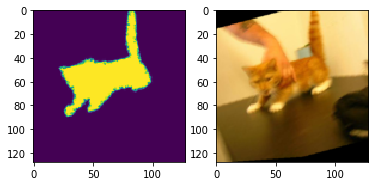

In [1017]:
# for testing only
transform = T.ToTensor()
transform_1 = T.Compose([
    T.RandomHorizontalFlip(),
    T.RandomRotation(20),
    T.RandomAffine(10, translate=[0, 0.1], scale=[0.8, 1], shear=2),
    T.RandomResizedCrop(128,scale=(0.75, 1.0),ratio=(0.75,1)),
    T.Resize((128,128)),
    T.ToTensor()
])
gen = catDataset("cat_data/Train",transform)
x, y = gen.__getitem__(0)
print(x.shape)
print(y.shape)
plt.subplot(1,2,1)
plt.imshow(y.permute(1, 2, 0).squeeze())
plt.subplot(1,2,2)
plt.imshow(x.permute(1, 2, 0))

7390
torch.Size([3, 128, 128])
torch.Size([1, 128, 128])


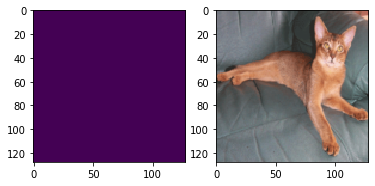

In [504]:
#for testing only
transform = T.Compose([
    T.Resize((128,128)),
    T.ToTensor()
])
gen = catDataset("new_data",transform,1)
x, y = gen.__getitem__(136)
print(x.shape)
print(y.shape)
plt.subplot(1,2,1)
plt.imshow(y.permute(1, 2, 0).squeeze())
plt.subplot(1,2,2)
plt.imshow(x.permute(1, 2, 0))


In [122]:
class DoubleConv(nn.Module):
    def __init__(self, input_channel, output_channel):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(input_channel, output_channel, 3, padding=1),
            nn.BatchNorm2d(output_channel),
            nn.ReLU(inplace=True),
            nn.Conv2d(output_channel, output_channel, 3, padding=1),
            nn.BatchNorm2d(output_channel),
            nn.ReLU(inplace=True)
        )
        
    def forward(self, x):
        return self.conv(x)

In [110]:
class Unet(nn.Module):
    def __init__(self,input_channel,output_channel):
        super().__init__()
        self.conv1 = DoubleConv(input_channel, 64)
        self.pool1 = nn.MaxPool2d(2)
        self.conv2 = DoubleConv(64, 128)
        self.pool2 = nn.MaxPool2d(2)
        self.conv3 = DoubleConv(128, 256)
        self.pool3 = nn.MaxPool2d(2)
        self.conv4 = DoubleConv(256, 512)
        self.pool4 = nn.MaxPool2d(2)
        self.conv5 = DoubleConv(512, 1024)
        self.up6 = nn.ConvTranspose2d(1024, 512, 2, stride=2)
        self.conv6 = DoubleConv(1024, 512)
        self.up7 = nn.ConvTranspose2d(512, 256, 2, stride=2)
        self.conv7 = DoubleConv(512, 256)
        self.up8 = nn.ConvTranspose2d(256, 128, 2, stride=2)
        self.conv8 = DoubleConv(256, 128)
        self.up9 = nn.ConvTranspose2d(128, 64, 2, stride=2)
        self.conv9 = DoubleConv(128, 64)
        self.conv10 = nn.Conv2d(64,output_channel, 1)

    def forward(self,x):
        c1=self.conv1(x)
        p1=self.pool1(c1)
        c2=self.conv2(p1)
        p2=self.pool2(c2)
        c3=self.conv3(p2)
        p3=self.pool3(c3)
        c4=self.conv4(p3)
        p4=self.pool4(c4)
        c5=self.conv5(p4)
        up_6= self.up6(c5)
        merged6 = torch.cat([up_6, c4], 1)
        c6=self.conv6(merged6)
        up_7=self.up7(c6)
        merged7 = torch.cat([up_7, c3], 1)
        c7=self.conv7(merged7)
        up_8=self.up8(c7)
        merged8 = torch.cat([up_8, c2], 1)
        c8=self.conv8(merged8)
        up_9=self.up9(c8)
        merged9=torch.cat([up_9,c1], 1)
        c9=self.conv9(merged9)
        c10=self.conv10(c9)
        output = nn.Sigmoid()(c10)
        return output


In [2239]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = Unet(3,1).to(device)
criterion = torch.nn.BCELoss()
optimizer = optim.Adam(model.parameters(),0.0001)

transform = T.Compose([
    T.Resize((128,128)),
    T.ToTensor()
])
transform_1 = T.Compose([
    T.RandomHorizontalFlip(),
    T.RandomRotation(30),
    T.RandomAffine(0, translate=[0, 0.2], scale=[0.8, 1], shear=1),
    T.RandomResizedCrop(128,scale=(0.8, 1.0),ratio=(0.85,1)),
    T.Resize((128,128)),
    T.ToTensor()
])

def bce_loss(pred, target):
    loss = -torch.mean(target*torch.log(pred) + (1-target)*torch.log(1-pred)).sum()
    return loss

def dice_loss(image,label):
    product = image.view(-1)*label.view(-1)
    intersection = torch.sum(product)
    coefficient = (2.*intersection +1.) / (torch.sum(image)+torch.sum(label) +1.)
    loss = 1. - coefficient
    return loss

def train_model(model,num_epoch,criterion,optimizer,dataloader,weight):
    best_sdc_score = 0
    print("start training")
    count = 0
    for epoch in range(num_epoch):
        running_loss = 0
        sdc = 0
        for imgs, labels in dataloader:
            count = count+1
            optimizer.zero_grad()
            imgs = imgs.to(device)
            labels = labels.to(device)
            outputs = model(imgs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            sdc += (1. - dice_loss(outputs, labels))
        if sdc/len(dataloader) > best_sdc_score:
            best_sdc_score = sdc/len(dataloader)
            torch.save(model.state_dict(),weight)
        print("Epoch: {}/{}".format(epoch+1, num_epoch),
              "Training Loss: {:.3f}".format(running_loss/len(dataloader)))
        
#                "Sørensen–Dice coefficient: {:.3f}".format(sdc/len(dataloader)),
#                "best coefficient: {:.3f}".format(best_sdc_score))


In [2240]:
model.train()
cat_dataset_train = catDataset("cat_data/Train",transform)
dataloader_train = DataLoader(cat_dataset_train,4)
num_epoch = 20
train_model(model,num_epoch,bce_loss,optimizer,dataloader_train,'weights_1.pth')

start training
Epoch: 1/20 Training Loss: 0.665
Epoch: 2/20 Training Loss: 0.545
Epoch: 3/20 Training Loss: 0.460
Epoch: 4/20 Training Loss: 0.422
Epoch: 5/20 Training Loss: 0.382
Epoch: 6/20 Training Loss: 0.383
Epoch: 7/20 Training Loss: 0.355
Epoch: 8/20 Training Loss: 0.332
Epoch: 9/20 Training Loss: 0.290
Epoch: 10/20 Training Loss: 0.269
Epoch: 11/20 Training Loss: 0.259
Epoch: 12/20 Training Loss: 0.267
Epoch: 13/20 Training Loss: 0.261
Epoch: 14/20 Training Loss: 0.239
Epoch: 15/20 Training Loss: 0.208
Epoch: 16/20 Training Loss: 0.203
Epoch: 17/20 Training Loss: 0.188
Epoch: 18/20 Training Loss: 0.184
Epoch: 19/20 Training Loss: 0.206
Epoch: 20/20 Training Loss: 0.208


In [2252]:
transform = T.Compose([
    T.Resize((128,128)),
    T.ToTensor()
])
cat_dataset_test = catDataset("cat_data/Test",transform)
dataloader_test = DataLoader(cat_dataset_test)
model.load_state_dict(torch.load('weights_1.pth'))
result = []
def test_model(model,dataloader):
    with torch.no_grad():
        sdc = 0
        for imgs, labels in dataloader:
            imgs = imgs.to(device)
            labels = labels.to(device)
            outputs = model(imgs)
            result.append((labels,outputs,imgs))
            sdc += (1. - dice_loss(outputs, labels))
        print("Sørensen–Dice coefficient: {:.3f}".format(sdc/len(dataloader)))
     

In [2253]:
model.eval()
test_model(model,dataloader_test)

Sørensen–Dice coefficient: 0.629


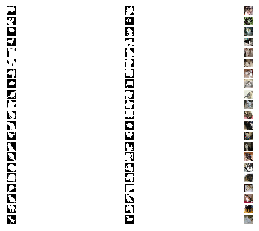

In [2251]:
def show_output(result,index):
    plt.subplot(21,3,index*3+1)
    plt.imshow(result[index][0].cpu().squeeze(),cmap="gray")
#     plt.title('ground truth masks')
    plt.axis('off')
    plt.subplot(21,3,index*3+2)
    res = np.array(result[index][1].cpu().squeeze())
    res = res > 0.2
    plt.imshow(res,cmap="gray")
#     plt.title('predicted masks')
    plt.axis('off')
    plt.subplot(21,3,index*3+3)
    plt.imshow(result[index][2].cpu().squeeze().permute(1, 2, 0))
    plt.axis('off')
#     plt.title('image')

for i in range(21):
    show_output(result,i)
    plt.axis('off')
    plt.savefig('q1_BCE.jpg',dpi=1000)
# show_output(result,0)

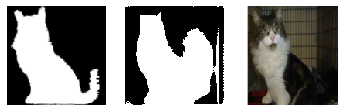

In [2249]:
def display_output(result,index):
    plt.subplot(1,3,1)
    plt.imshow(result[index][0].cpu().squeeze(),cmap="gray")
#     plt.title('ground truth masks')
    plt.axis('off')
    plt.subplot(1,3,2)
    res = np.array(result[index][1].cpu().squeeze())
    res = res > 0.1
    plt.imshow(res,cmap="gray")
#     plt.title('predicted masks')
    plt.axis('off')
    plt.subplot(1,3,3)
    plt.imshow(result[index][2].cpu().squeeze().permute(1, 2, 0))
#     plt.title('image')
    plt.axis('off')
display_output(result,13)

7390
torch.Size([3, 128, 128])
torch.Size([1, 128, 128])


tensor(1.)

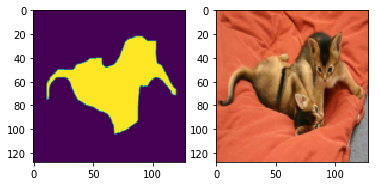

In [1141]:
transform = T.Compose([
    T.Resize((128,128)),
    T.ToTensor()
])
new_dataset_train = catDataset("new_data",transform,1)
x, y = new_dataset_train.__getitem__(6)
print(x.shape)
print(y.shape)
plt.subplot(1,2,1)
plt.imshow(y.permute(1, 2, 0).squeeze())
plt.subplot(1,2,2)
plt.imshow(x.permute(1, 2, 0))
new_dataloader_train = DataLoader(new_dataset_train,5)

In [ ]:
model.train()
train_model(model,30,dice_loss,optimizer,new_dataloader_train,'weights_new_1.pth')

In [ ]:
model.train()
model.load_state_dict(torch.load('weights_new_1.pth'))
train_model(model,30,dice_loss,optimizer,dataloader_train,'weights_transfer_2_1.pth')

In [1954]:
model.eval()
model.load_state_dict(torch.load('weights_transfer_2_1.pth'))
result = []
test_model(model,dataloader_test)

Sørensen–Dice coefficient: 0.898


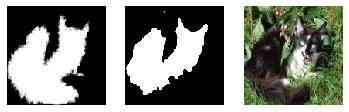

In [1955]:
display_output(result,1)

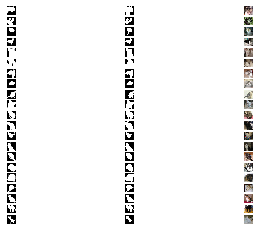

In [1902]:
# for i in range(21):
#     show_output(result,i)
#     plt.savefig('q2.jpg',dpi=1000)

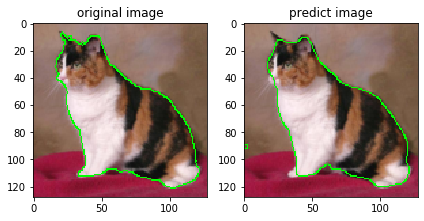

In [2024]:
def draw_line(result,index):
    label,outputs,images = result[index]
    label = np.array(label.cpu().squeeze())*255
    outputs = np.array(outputs.cpu().squeeze())*255
    images = np.array(images.cpu().squeeze().permute(1, 2, 0))
    x = np.copy(images)
    y = np.copy(images)
    
    label_canny = cv2.Canny(np.uint8(label), 50, 120)
    x[label_canny == 255] = [0,1,0]
    plt.subplot(1,2,1)
    plt.imshow(x)
    plt.title("original image")
    outputs_canny = cv2.Canny(np.uint8(outputs), 50, 120)
    y[outputs_canny == 255] = [0,1,0]
    plt.subplot(1,2,2)
    plt.imshow(y)
    plt.title("predict image")
    plt.tight_layout()
    
draw_line(result,18)